In [1]:
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models, utils
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn, optim
import torch.nn.functional as F
import torch
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
import time
import copy

In [2]:
data_dir = "./data/"

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])
}

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir, transform=data_transforms['train'])
validation_data = datasets.ImageFolder(data_dir, transform=data_transforms['val'])

In [3]:
def train_val_split(dataset, validation_size):
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(validation_size * num_train))
    
    train_idx, val_idx = indices[:split], indices[split:]
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    
    return train_sampler, val_sampler

In [4]:
train_sampler, val_sampler = train_val_split(train_data, 0.8)

In [5]:
train_loader = DataLoader(train_data, batch_size=128, sampler=train_sampler, num_workers=8)
val_loader = DataLoader(validation_data, batch_size=128, sampler=val_sampler, num_workers=8)

## Image Visualization

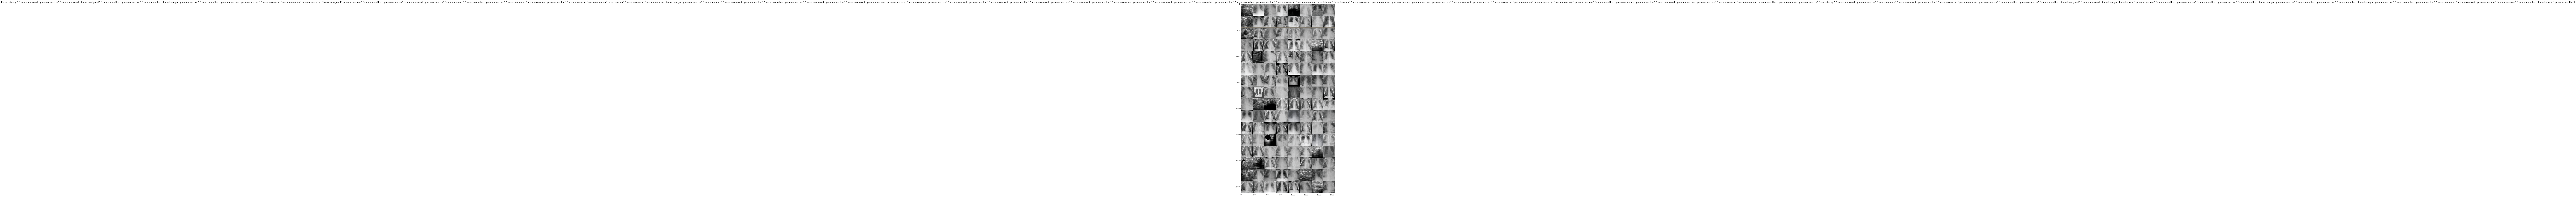

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(30,20))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
# Get a batch of training data
inputs, classes = next(iter(val_loader))
# Make a grid from batch
out = utils.make_grid(inputs)

class_names = train_data.classes
imshow(out, title=[class_names[x] for x in classes])

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Resnet 18, ResNext101

In [8]:
model = models.resnext101_32x8d(pretrained=True, progress=True)
# model = models.resnet18(pretrained=True, progress=True)

for param in model.parameters():
    param.requires_grad = False
    
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(train_data.classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

## VGG-16/19

In [9]:
# model_vgg19 = models.vgg19_bn(pretrained=True, progress=True)
# # model_vgg19 = models.vgg16_bn(pretrained=True, progress=True)

# for param in model_vgg19.features.parameters():
#     param.requires_grad = False
    
# num_features = model_vgg19.classifier[6].in_features
# model_vgg19.classifier[6] = nn.Linear(num_features, len(train_data.classes))

# model_vgg19 = model_vgg19.to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model_vgg19.parameters(), lr=0.001, momentum=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

## GoogleNet

In [10]:
# model_googlenet = models.googlenet(pretrained=True, progress=True, transform_input= True)

# for param in model_googlenet.parameters():
#     param.requires_grad = False
    
# num_features = model_googlenet.fc.in_features
# model_googlenet.fc = nn.Linear(num_features, len(train_data.classes))
# model_googlenet = model_googlenet.to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model_googlenet.fc.parameters(), lr=0.001, momentum=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [11]:
print(model.fc)

Linear(in_features=2048, out_features=8, bias=True)


### Train

In [12]:
def train(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    train_losses = []
    val_losses = []
    
    best_model = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0
    
    for epoch in range(num_epochs):
        print("\n========== Epoch: {}/{} ==========".format(epoch+1, num_epochs))
        running_loss = 0.0
        
        model.train() # set to train mode
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            start = time.time()

            optimizer.zero_grad() #zero out the gradients

            log_ps = model.forward(inputs) # feed forward
            train_loss = criterion(log_ps, labels) # calculate cross-entropy loss
            train_loss.backward() # backpropagation
            optimizer.step()

            running_loss += train_loss.item()

            torch.cuda.empty_cache()
            del inputs
            del labels
            del train_loss
            
        else:
            val_loss = 0.0
            total_predictions = 0.0
            correct_predictions = 0.0

            with torch.no_grad():
                model.eval() # set to evaluation mode
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)

                    log_ps = model.forward(inputs)
                    loss = criterion(log_ps, labels).detach()

                    val_loss += loss.item()

                    # Calculate accuracy
                    _, predicted = torch.max(log_ps, 1)
                    total_predictions += labels.size(0)
                    correct_predictions += (predicted == labels).sum().item()

                    torch.cuda.empty_cache()
                    del inputs
                    del labels
                    del loss

            accuracy = (correct_predictions/total_predictions)*100.0

            train_losses.append(running_loss/len(train_loader))
            val_losses.append(val_loss/len(val_loader))
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model = copy.deepcopy(model.state_dict())
                
                model_path = f'models/model_{accuracy:.5f}.pt'
                torch.save(model.state_dict(), model_path)

                print("Training Loss: {:.4f} ".format(running_loss/len(train_loader)),
                  f"Time: {(time.time() - start)/60:.3f} minutes \n",
                  "Validation Loss: {:.3f}\n".format(val_loss/len(val_loader)),
                  f'Accuracy: {accuracy:.5f}%')

                print("==========")
        
        scheduler.step() # # Decay Learning Rate
            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:5f}'.format(best_accuracy))
    
    # load best model
    model.load_state_dict(best_model)
    return (model, train_losses, val_losses)

In [13]:
# loaded_model = model_vgg19
# checkpoint = torch.load("models/model_86.26571.pt")
# loaded_model.load_state_dict(checkpoint)
# loaded_model.to(device)

In [14]:
trained_model, train_losses, val_losses = train(model, criterion, optimizer, scheduler, num_epochs=40)


========== Epoch: 1/40 ==========
Training Loss: 1.4261  Time: 0.367 minutes 
 Validation Loss: 0.912
 Accuracy: 80.16158%

========== Epoch: 2/40 ==========
Training Loss: 0.8727  Time: 0.386 minutes 
 Validation Loss: 0.644
 Accuracy: 82.49551%

========== Epoch: 3/40 ==========
Training Loss: 0.7058  Time: 0.381 minutes 
 Validation Loss: 0.535
 Accuracy: 84.29084%

========== Epoch: 4/40 ==========

========== Epoch: 5/40 ==========
Training Loss: 0.5773  Time: 0.386 minutes 
 Validation Loss: 0.460
 Accuracy: 85.36804%

========== Epoch: 6/40 ==========

========== Epoch: 7/40 ==========

========== Epoch: 8/40 ==========
Training Loss: 0.4879  Time: 0.351 minutes 
 Validation Loss: 0.429
 Accuracy: 85.72711%

========== Epoch: 9/40 ==========

========== Epoch: 10/40 ==========

========== Epoch: 11/40 ==========

========== Epoch: 12/40 ==========

========== Epoch: 13/40 ==========

========== Epoch: 14/40 ==========

========== Epoch: 15/40 ==========

========== Epoch: 16/40

KeyboardInterrupt: 

In [ ]:
# np.save("vgg16_train_losses", train_losses)
# np.save("vgg16_val_losses", val_losses)

## Results

### Resnet18
========== Epoch: ./. ========== \
Training Loss: 0.5135  Time: 10.906 minutes \
Validation Loss: 0.468 \
Accuracy: 84.02154%

==========

### Vgg16
========== Epoch: 12/40 ========== \
Training Loss: 0.4296  Time: 0.280 minutes \
 Validation Loss: 0.329 \
 Accuracy: 87.07361%
 
==========

### Vgg19
========== Epoch: 16/40 ========== \
Training Loss: 0.4416  Time: 0.297 minutes \
 Validation Loss: 0.322 \
 Accuracy: 86.89408%
 
==========

### ResNext101
========== Epoch: 16/40 ========== \
Training Loss: 0.4871  Time: 0.376 minutes \
 Validation Loss: 0.427 \
 Accuracy: 85.99641% 
 
==========

### Visualize model predictions

In [ ]:
def visualize_predictions(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
visualize_predictions(trained_model)